In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
import glob
import torchgeometry as tgm
from random import random

In [4]:
img = Image.open('../Final_data/normal/normal1st_pcd_18.png')
img_array = np.array(img)

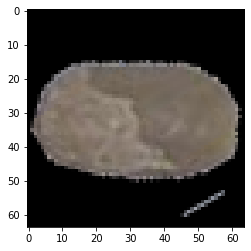

In [5]:
plt.imshow(img_array)

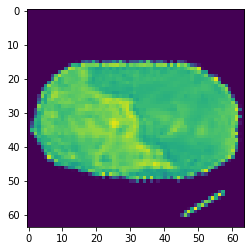

In [20]:
src = img_array
thres = 0
gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
plt.imshow(gray)
# 바이너리로 변환
ret, binary = cv2.threshold(gray,thres,255, cv2.THRESH_OTSU)
binary = cv2.bitwise_not(binary)


In [32]:
def imgPreprocessing(src, thres):
    ############################################################################
    # <이미지 노이즈 및 배경 제거>

    # 그레이 스케일로 변환
    gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    
    # 바이너리로 변환
    ret, binary = cv2.threshold(gray,thres,255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    # # 바이너리 이미지와 원본 이미지의 데이터가 일치하는 부분 만 다시 추출히기
    # tmp = np.zeros_like(src)
    # for y in range(64):
    #     for x in range(64):
    #         if (binary != 0)[y,x]:
    #             for i in range(3):
    #                 tmp[y,x,i] = src[y,x,i]
    
    # src_processed = tmp   

    # # 이미지 크기 정의
    height = src.shape[0]
    width = src.shape[1]
    src_processed = src
    ############################################################################
    # <생두 무게 중심 구하기>
    R = list()
    for y in range(height):
        for x in range(width):
            if binary[y,x]:            
                R.append([y, x])

    # 질량의 합
    M = len(R)

    R = np.array(R)
    R_x = R[:,1]
    R_y = R[:,0]

    R_x_sum = R_x.sum()
    R_y_sum = R_y.sum()

    center = np.round(R_x_sum/M) , (np.round(R_y_sum/M))

    height_center = center[0]
    width_center = center[1]

    # print('center:', height_center, width_center)

 
    ############################################################################
    # <객체 외부의 노이즈 데이터 처리하기>

    # 바이너리의 윤곽선 추출
    _, contours, hierachy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)    

    # 생두 객체 윤곽과 윤곽벡터 구하기
    contours_leng = [len(i) for i in contours if len(i) != 252]
    len_max = np.array(contours_leng).max()
    contour_vector = list()
    
    for i in contours:
        if len(i) == len_max:
            for point in i:
                contour_vector.append((point[0][1]-height_center, point[0][0]-width_center))
            
            # 윤곽 벡터 사이즈와 최대 사이즈 구하기
            vector_size = np.sqrt(np.array(contour_vector)[:,0]**2 + np.array(contour_vector)[:,1]**2 )
            max_size = vector_size.max()
    

    # 질량 벡터와 윤곽벡터를 비교하는 코드 짜기
    R_size = np.sqrt((R[:,1] - width_center) ** 2 + (R[:,0] - height_center) ** 2)
    R_total = np.hstack([R,R_size.reshape((R_size.shape[0],1))])

    # max_size 보다 큰 R 좌표들만 추출하기
    R_filtered = R_total[R_total[:,2] > max_size]


    # R_filtered의 좌표를 이용해서 노이즈 처리
    for i in R_filtered[:,:2]:
        src_processed[int(i[1]),int(i[0])] = 0

    ############################################################################
    # <이미지의 중심과 생두의 무게중심 일치시키기>
    
    # 1. 이미지 센터 좌표를 구한다 
    src_center = np.array([src_processed.shape[1] / 2, src_processed.shape[0] / 2])

    # 2. 객체의 중심을 구한다
    object_center = np.array([height_center, width_center])

    # 3. 이미지 중심과 객체의 중심의 차이를 구한다
    delta = object_center - src_center

    # 4. 이미지 이동
    height, width = src_processed.shape[:2]
    M = np.float32([[1, 0, -delta[0]], [0, 1, -delta[1]]]) # 이미지를 width 방향으로 delta[0]만큼 , hiehgt 방향으로 -delta[1]만큼
    img_translation = cv2.warpAffine(src_processed, M, (width,height))

    return src, binary, src_processed, img_translation


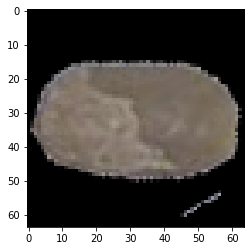

In [33]:
plt.imshow(imgPreprocessing(img_array, 0)[2])

In [ ]:
# 콩 모양 때문에 어쩔 수 없다.